In [1]:
import os

In [2]:
from tqdm import tqdm

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [4]:
from ase import io
from ase.visualize import view
from ase.build import sort, molecule
from ase.optimize import QuasiNewton, FIRE

In [5]:
from helpers import validate
from helpers import read_metrics

In [6]:
from pyace import PyACECalculator

In [7]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
# mpl.rcParams['font.family'] = 'Times'

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.top']=True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right']=True

In [8]:
calc = PyACECalculator('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.yaml',
    keep_extrapolative_structures=True,
    gamma_lower_bound=1.2,
    gamma_upper_bound=10,
    stop_at_large_extrapolation=False)
calc.set_active_set('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.asi')

In [9]:
def linear_fn(x, a, b):
    return a*x + b

In [10]:
import os
import warnings
def read_log(path):
    os.system(f'cat {path}/lmp.out | grep -e Step -e Loop -n > read_log')
    file = open('read_log').readlines()
    os.system('rm read_log')
    log_lst = list()
    for i in range(0,len(file),2):
        try:
                n1 = int(file[i].replace(':',' ').split()[0])
                n2 = int(file[i+1].replace(':',' ').split()[0])
                log_lst.append(pd.read_csv(f'{path}/lmp.out',
                                   skiprows=n1-1, nrows=n2-n1-1, sep= '\s+'))
        except:
            break

    if(len(file)%2 ==0):
        return log_lst
    else:
        warnings.warn('Last run is not finished')            
        n = int(file[-1].replace(':',' ').split()[0])
        log_lst.append(pd.read_csv(f'{path}/lmp.out', skiprows=n-1, sep= '\s+'))

    return log_lst

In [11]:
def write_lmp_file(P, T, path, pot_dir, barostat='iso', n_steps_eq = 2*10**3, n_steps_pr = 2*10**7):
    s= np.random.randint(99999)
    lines= ['\n',
 'units\t\tmetal\t\t\t\t\t\t## E in [eV], t in [ps], P in [10000 Pa], l in [A]\n',
 'atom_style\tatomic\t\t\t\t\t\t## mass x y z vx vy vz \n',
 '\n',
 'neighbor\t0.5 bin\t\t\t\t\t\t## neighbor list, skin = 0.5 Angstrom\n',
 'neigh_modify\tevery 2 delay 10 check yes\t\t\t## update of neighbor list\n',
 '\n',
 '############################## main variables\n',
f'variable        seed equal {s}\n',
 '\n',
f'variable\ttemperature equal {T}\n',
 'variable\ttempDamp equal 0.1\n',
 '\n',
f'variable        pressure equal {P}\n',
 'variable        pressureDamp equal 1.0 \t\t\t\t# This is 1 ps\n',
 '\n',
 '##############################\n',
 '\n',
 'read_data water.dat\n',
 '\n',
 'mass\t\t1 1.008    # H\n',
 'mass\t\t2 15.9994  # O\n',
 '\n',
 '\n',
 'pair_style\tpace/extrapolation\n',
 f'pair_coeff\t* * {pot_dir}/interim_potential_ladder_step_1.yaml\
 {pot_dir}/interim_potential_ladder_step_1.asi H O\n',
 '\n',
 'fix pace_gamma all pair 1000 pace/extrapolation gamma 1\n',
 'compute max_pace_gamma all reduce max f_pace_gamma\n',
 'variable dump_skip equal "c_max_pace_gamma < 10"\n',
 '\n',
 'dump pace_dump all custom 1000 extrapolative_structures.dump id type x y z f_pace_gamma\n',
 'dump_modify pace_dump skip v_dump_skip\n',
 'dump_modify pace_dump element H O\n',
 '\n',
 'variable max_pace_gamma equal c_max_pace_gamma',
 '\n',
 '\n',
 'timestep\t0.0005\t\t\t\t\t\t## timestep = 0.0005*ps = 0.5 fs\n',
 '\n',
 'thermo\t\t100\n',
 'thermo_style custom step etotal pe ke press temp vol enthalpy density c_max_pace_gamma\n',
 '\n',
 '\n',
 'min_style cg\n',
 'minimize 0.0 5.0e-4 10000 100000\n'
 '\n',
 '################## equilibration of main calculation\n',
 '# Equilibrate to specified number of ice\n',
 '\n',
f'fix             3 all nph {barostat} '+' ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
f'run {n_steps_eq} \n',
 '\n',
 'unfix 3\n',
 'unfix 4\n',
 '\n',
 '################## main calculation\n',
 '\n',
 '#dump \t\t3 all custom 1000 traj.lammpstrj id type element x y z\n',
 '#dump_modify     3 element H O\n',
 '\n',
 '\n',
f'fix             3 all nph {barostat} '+'${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
f'run             {n_steps_pr}\n',
 '\n',
 'unfix\t\t3\n',
 'unfix\t\t4\n',
 'write_data data.data']
    fr = open(f'{path}/in.lammps', 'w')
    fr.writelines(lines)
    fr.close()
    return

In [12]:
def plot_stats_eq(path):
    #Read the data from the path
    
    data = np.loadtxt(f'{path}/COLVAR-EQUILIBRATE')
    log = read_log(f'{path}/')[0]
    
    fig, ax = plt.subplots(figsize=(16,5), ncols=3)
    
    ax[0].plot(data[:,2], alpha=1.0, c='C0')
    ax[0].axhline(np.average(data[:,2]), ls='--', color='C0', lw=2)
    # ax[0].set_xlabel('Time [ps]')
    # ax[0].set_ylabel('A $\mathrm{[\AA^{2}]}$')
    ax[0].set_title('$\mathrm{n_{ice}}$')

    ax[1].plot(log.Temp, alpha=1.0, c='k')
    ax[1].axhline(log.Temp.mean(), ls='--', color='k', lw=2)
    # ax[1].set_xlabel('Time [ps]')
    ax[1].set_title('Temperature')

    ax[2].plot(log.Press, alpha=1.0, c='k')
    ax[2].axhline(log.Press.mean(), ls='--', color='k', lw=2)
    # ax[2].set_xlabel('Time [ps]')
    ax[2].set_title('Pressure')
    
def plot_stats(path, skip=0):
    #Read the data from the path
    
    log = read_log(f'{path}/')[-1]
        
    fig, ax = plt.subplots(figsize=(16,4), ncols=3)
    
    ax[0].plot(log.Step[skip:]*5e-7, log.Enthalpy[skip:], alpha=1., c='k')
    ax[0].axhline(log.Enthalpy[skip:].mean(), ls='--', color='w', lw=2)
    ax[0].set_xlabel('Time [ns]')
    ax[0].set_title('H')

    ax[1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=1., c='k')
    ax[1].axhline(log.Temp[skip:].mean(), ls='--', color='w', lw=2)
    ax[1].set_xlabel('Time [ns]')
    ax[1].set_title('T [K]')

    ax[2].plot(log.Step[skip:]*5e-7,log.Press[skip:], alpha=1., c='k')
    ax[2].axhline(log.Press[skip:].mean(), ls='--', color='w', lw=2)
    ax[2].set_xlabel('Time [ns]')
    ax[2].set_title('P [bar]')

In [14]:
path = '/home/users/saadie5f/piaggi/phase_diagram/TIP4P-Ice-Phase-Diagram/\
GibbsDuhemSimulations/IceIII_Liquid/Initial/IceIII/iceIII.data'
ph_1 = io.read(f'{path}',
                format='lammps-data')
ph_1.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, ph_1.get_chemical_symbols())))
np.unique(ph_1.get_chemical_symbols())
ph_1.wrap()
view(ph_1, viewer='nglview')

In [15]:
ph_1.set_calculator(calc)
opt_ph_1 = QuasiNewton(ph_1)
opt_ph_1.run(fmax=1)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 14:58:11    -4664.396143*       2.4560


/home/users/saadie5f/miniconda3/envs/ace/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


BFGSLineSearch:    1[  2] 14:58:13    -4682.395237*       0.9694


True

In [17]:
path = '/home/users/saadie5f/piaggi/phase_diagram/TIP4P-Ice-Phase-Diagram/GibbsDuhemSimulations\
/IceIII_Liquid/Initial/Liquid/water.data'
ph_2 = io.read(f'{path}',
                format='lammps-data')
ph_2.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, ph_2.get_chemical_symbols())))
np.unique(ph_2.get_chemical_symbols())
ph_2.wrap()
view(ph_2, viewer='nglview')

In [18]:
ph_2.set_calculator(calc)
opt_ph_2 = QuasiNewton(ph_2)
opt_ph_2.run(fmax=1)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 14:58:27    -4122.585231*       2.2666
BFGSLineSearch:    1[  2] 14:58:29    -4134.262964*       0.8274


True

In [27]:
def run_md(P, T, ph_1, ph_2, path_ph1, path_ph2, barostat_ph1, barostat_ph2, 
           n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip=0):
    try:
        os.mkdir(path_ph1+f'_T_{T}_P_{P}')
        os.chdir(path_ph1+f'_T_{T}_P_{P}')
        io.write('water.dat', ph_1, format='lammps-data', specorder=['H', 'O'])
        write_lmp_file(P, T, path_ph1+f'_T_{T}_P_{P}', pot_dir, barostat_ph1, n_steps_eq_ph1, n_steps_pr_ph1)
        os.system('export CUDA_VISIBLE_DEVICES=0;\
        nohup lmp_volta -k on g 1  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out')
        print(f'Simulations_ph1_T_{T}_P_{P} has been done')
    except:
        print(f'Simulations_ph1_T_{T}_P_{P} has been executed and will be used')
    
    try:
        os.mkdir(path_ph2+f'_T_{T}_P_{P}')
        os.chdir(path_ph2+f'_T_{T}_P_{P}')
        io.write('water.dat', ph_2, format='lammps-data', specorder=['H', 'O'])
        write_lmp_file(P, T, path_ph2+f'_T_{T}_P_{P}', pot_dir, barostat_ph2, n_steps_eq_ph2, n_steps_pr_ph2)
        os.system('export CUDA_VISIBLE_DEVICES=0;\
        nohup lmp_volta -k on g 1  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out')
        print(f'Simulations_ph2_T_{T}_P_{P} has been done')
    except:
        print(f'Simulations_ph2_T_{T}_P_{P} has been executed and will be used')
    
    n_mols_ph1 = int(len(ph_1)/3)
    n_mols_ph2 = int(len(ph_2)/3)
    
    log_ph1 = read_log(path_ph1+f'_T_{T}_P_{P}')[-1]
    log_ph2 = read_log(path_ph2+f'_T_{T}_P_{P}')[-1]

    h_ph1=np.mean(log_ph1.Enthalpy[skip:],axis=0)/n_mols_ph1
    vol_ph1=np.mean(log_ph1.Volume[skip:],axis=0)/n_mols_ph1

    h_ph2=np.mean(log_ph2.Enthalpy[skip:],axis=0)/n_mols_ph2
    vol_ph2=np.mean(log_ph2.Volume[skip:],axis=0)/n_mols_ph2
    
    
    c_bar_eV_Acube=6.241509e-7
    return 1/(T*(vol_ph1-vol_ph2)*c_bar_eV_Acube/(h_ph1-h_ph2))

In [29]:
pot_dir = '/home/users/saadie5f/piaggi/phase_diagram/upfit/10000_ladder/asi'

path_ph1 = '/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/iii-liq/iii'
path_ph2 = '/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/iii-liq/liq'

  
T = 270.864; P = 5000; T_step = -2
n_steps_eq_ph1 = 2*10**4; n_steps_pr_ph1 = 2*10**5
n_steps_eq_ph2 = 2*10**4; n_steps_pr_ph2 = 2*10**6
barostat_ph1 = 'aniso'; barostat_ph2 = 'aniso'

skip = 100
n_pnts = 20

T_lst = list();
P_lst = list();

for i in range(n_pnts):
    T_lst.append(T); P_lst.append(P)
    
    k1 = run_md(P, T, ph_1, ph_2, path_ph1, path_ph2, barostat_ph1, barostat_ph2,
                    n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    k2 = run_md(P + 0.5 * T_step * k1, T + 0.5 * T_step, ph_1, ph_2, path_ph1, path_ph2,
                barostat_ph1, barostat_ph2,
                n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    k3 = run_md(P + 0.5 * T_step * k2, T + 0.5 * T_step, ph_1, ph_2, path_ph1, path_ph2, 
                barostat_ph1, barostat_ph2,
                n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    k4 = run_md(P + T_step * k3, T + T_step, ph_1, ph_2, path_ph1, path_ph2, 
                barostat_ph1, barostat_ph2,
                n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    P += (1./6.) * T_step * (k1 + 2*k2 + 2*k3 + k4)
    T += T_step

Simulations_ph1_T_270.864_P_5000 has been done
Simulations_ph2_T_270.864_P_5000 has been done
Simulations_ph1_T_269.864_P_4256.049327225251 has been done
Simulations_ph2_T_269.864_P_4256.049327225251 has been done
Simulations_ph1_T_269.864_P_4498.594316612277 has been done
Simulations_ph2_T_269.864_P_4498.594316612277 has been done
Simulations_ph1_T_268.864_P_3782.509665025213 has been done
Simulations_ph2_T_268.864_P_3782.509665025213 has been done
Simulations_ph1_T_268.864_P_3859.35814675668 has been done
Simulations_ph2_T_268.864_P_3859.35814675668 has been done
Simulations_ph1_T_267.864_P_3403.2741748577746 has been done
Simulations_ph2_T_267.864_P_3403.2741748577746 has been done
Simulations_ph1_T_267.864_P_3491.459939991733 has been done
Simulations_ph2_T_267.864_P_3491.459939991733 has been done
Simulations_ph1_T_266.864_P_3116.921445964897 has been done
Simulations_ph2_T_266.864_P_3116.921445964897 has been done
Simulations_ph1_T_266.864_P_3112.053484817921 has been done
Simula

Simulations_ph2_T_239.86399999999998_P_498.66734543018674 has been done
Simulations_ph1_T_238.86399999999998_P_466.5442844014822 has been done
Simulations_ph2_T_238.86399999999998_P_466.5442844014822 has been done
Simulations_ph1_T_238.86399999999998_P_472.1950722074089 has been done
Simulations_ph2_T_238.86399999999998_P_472.1950722074089 has been done
Simulations_ph1_T_237.86399999999998_P_442.66975705324217 has been done
Simulations_ph2_T_237.86399999999998_P_442.66975705324217 has been done
Simulations_ph1_T_237.86399999999998_P_444.003463531159 has been done
Simulations_ph2_T_237.86399999999998_P_444.003463531159 has been done
Simulations_ph1_T_236.86399999999998_P_407.16119041723175 has been done
Simulations_ph2_T_236.86399999999998_P_407.16119041723175 has been done
Simulations_ph1_T_236.86399999999998_P_413.20008958179227 has been done
Simulations_ph2_T_236.86399999999998_P_413.20008958179227 has been done
Simulations_ph1_T_235.86399999999998_P_384.6941612372924 has been done
S

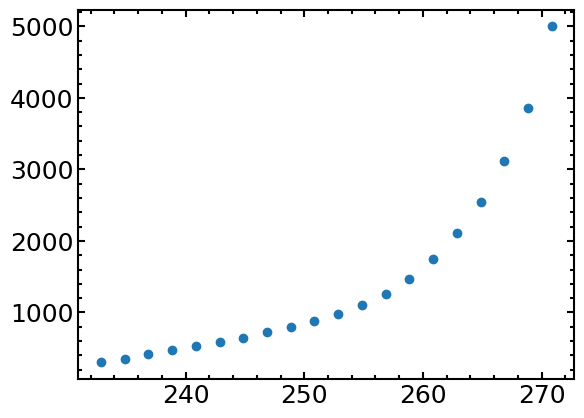

In [30]:
plt.scatter(T_lst, P_lst)

In [32]:
np.savetxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/iii_liq.dat',[T_lst,np.array(P_lst)*1e-4])

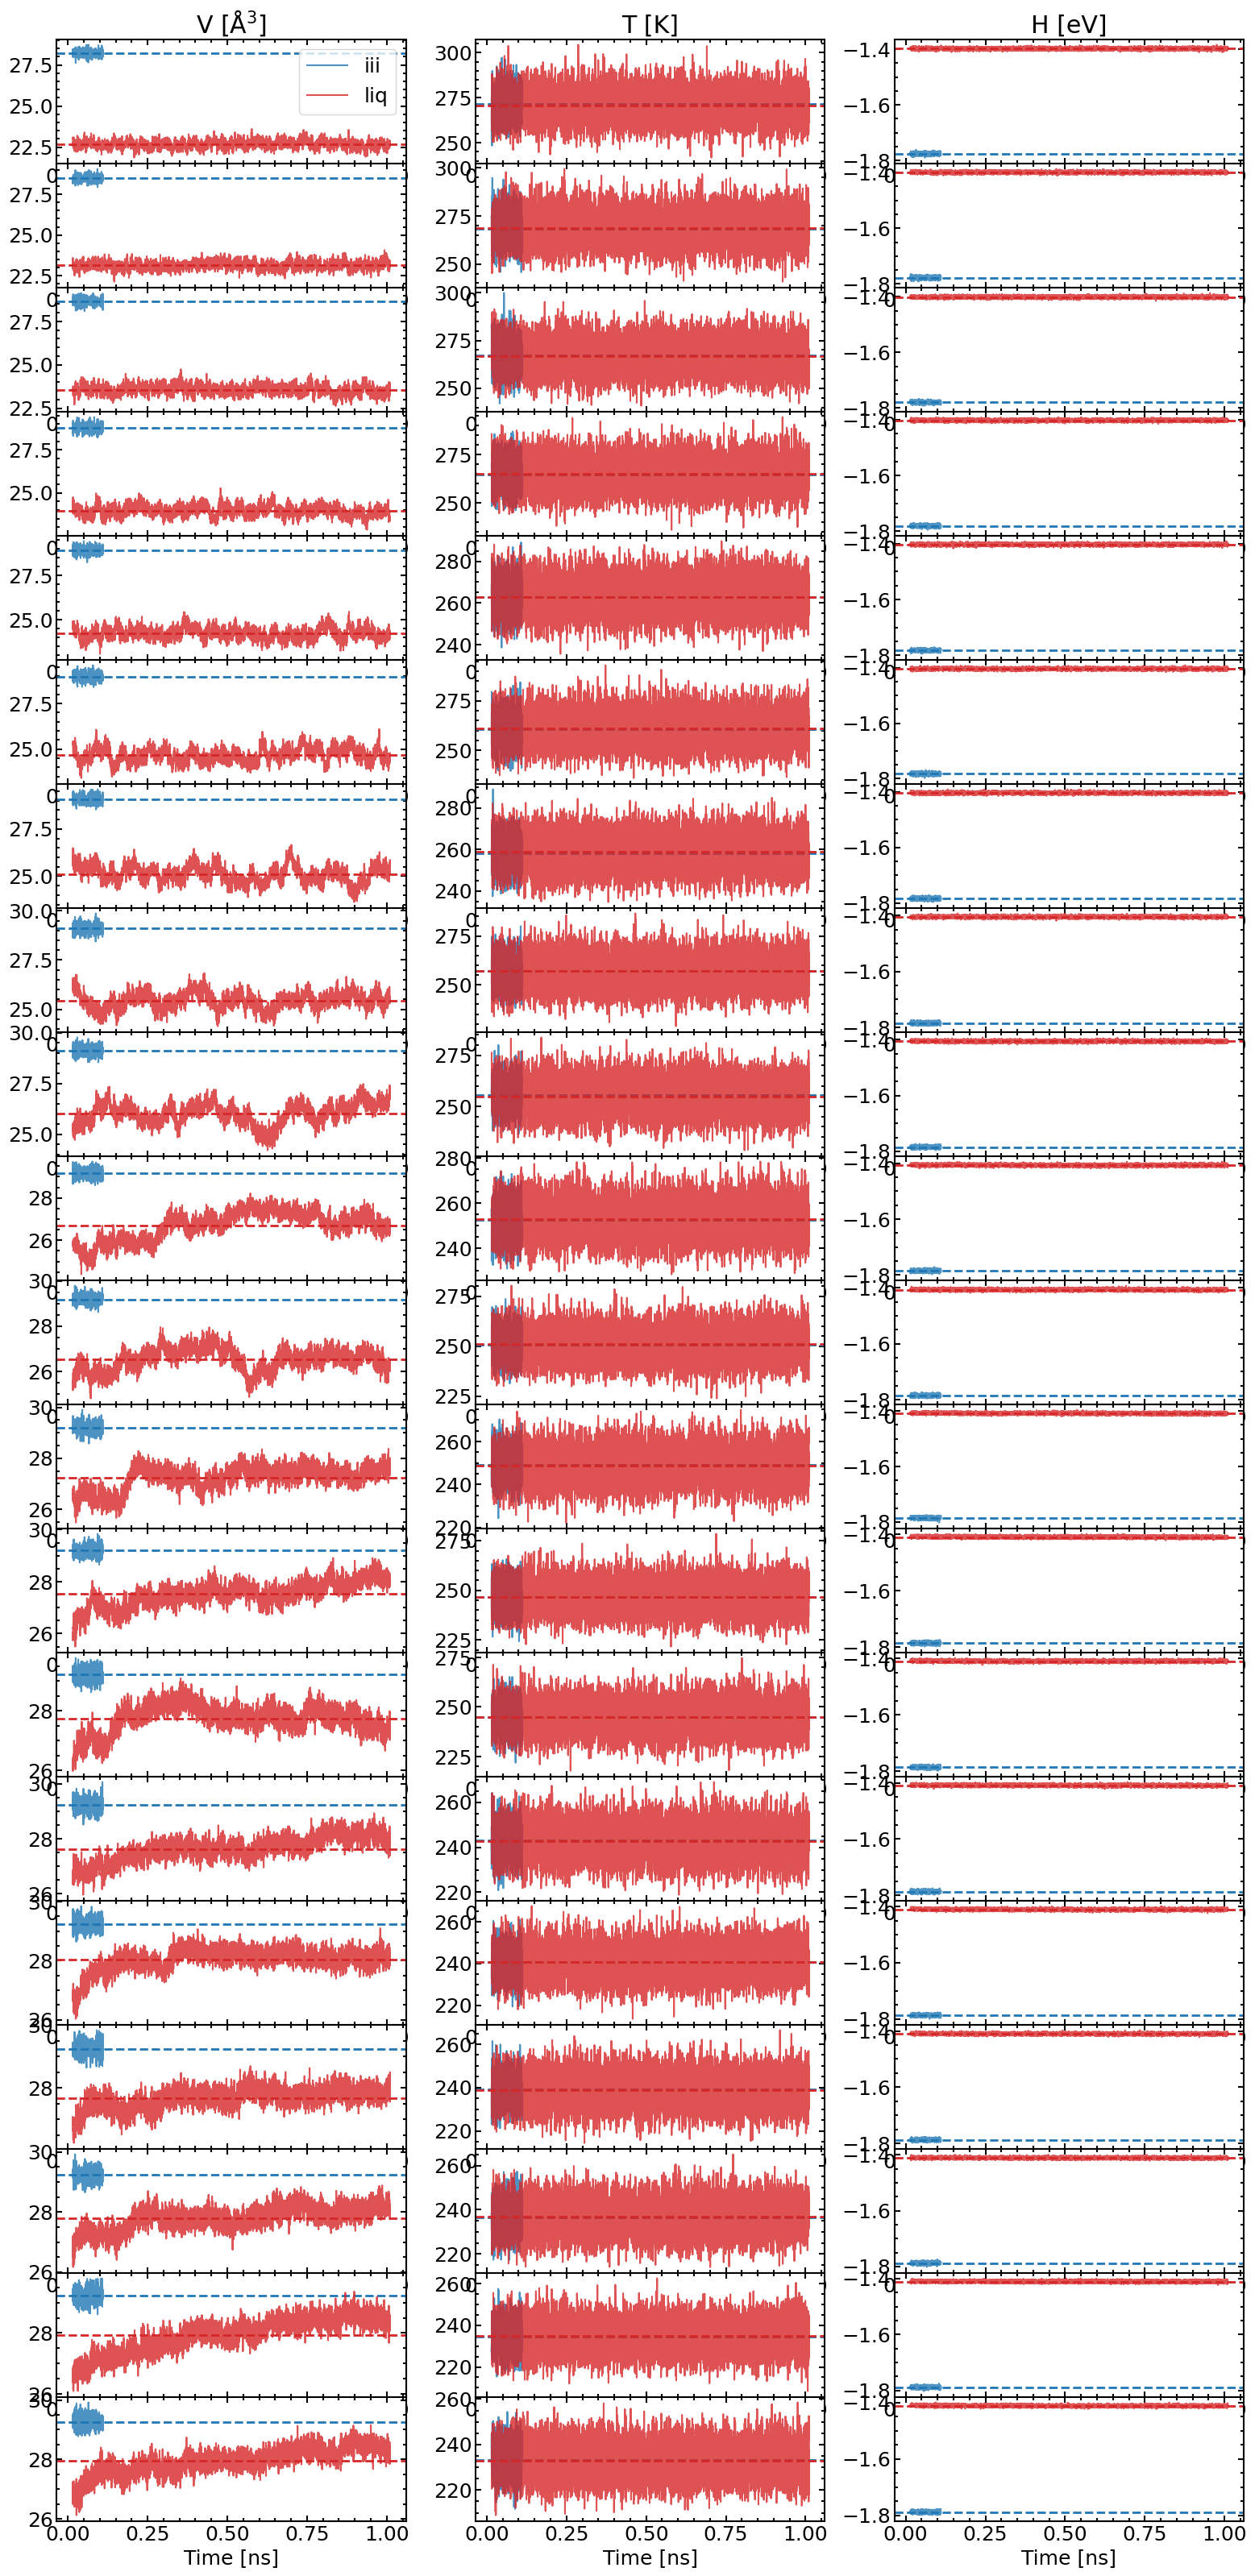

In [37]:
fig, ax = plt.subplots(figsize=(19,40), ncols=3, nrows=n_pnts)
fig.subplots_adjust(hspace=0)
alpha = 0.8
skip=100
for i in range(n_pnts):
    path = f'/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/iii-liq/iii_T_{T_lst[i]}_P_{P_lst[i]}'
    log = read_log(f'{path}')[-1]
        
    
    ax[i,0].plot(log.Step[skip:]*5e-7, log.Volume[skip:]/(len(ph_2)/3), alpha=alpha, c='C0', label='iii')
    ax[i,0].axhline(log.Volume[skip:].mean()/(len(ph_2)/3), ls='--', color='C0', lw=2)
    
    ax[i,1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=alpha, c='C0')
    ax[i,1].axhline(log.Temp[skip:].mean(), ls='--', color='C0', lw=2)

    ax[i,2].plot(log.Step[skip:]*5e-7,log.Enthalpy[skip:]/len(ph_2)/3, alpha=alpha, c='C0')
    ax[i,2].axhline(log.Enthalpy[skip:].mean()/len(ph_2)/3, ls='--', color='C0', lw=2)
#     print(log.Enthalpy[skip:].mean()/len(ph_2)/3)
    
    path = f'/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/iii-liq/liq_T_{T_lst[i]}_P_{P_lst[i]}'
    log = read_log(f'{path}')[-1]
        
    
    ax[i,0].plot(log.Step[skip:]*5e-7, log.Volume[skip:]/(len(ph_1)/3), alpha=alpha, c='C3', label='liq')
    ax[i,0].axhline(log.Volume[skip:].mean()/(len(ph_1)/3), ls='--', color='C3', lw=2)
    
    ax[i,1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=alpha, c='C3')
    ax[i,1].axhline(log.Temp[skip:].mean(), ls='--', color='C3', lw=2)

    ax[i,2].plot(log.Step[skip:]*5e-7,log.Enthalpy[skip:]/len(ph_1)/3, alpha=alpha, c='C3')
    ax[i,2].axhline(log.Enthalpy[skip:].mean()/len(ph_1)/3, ls='--', color='C3', lw=2)
#     print(log.Enthalpy[skip:].mean()/len(ph_1)/3)


ax[i,0].set_xlabel('Time [ns]')
ax[0,0].set_title('V [$\mathrm{\AA^{3}}$]')

ax[i,1].set_xlabel('Time [ns]')
ax[0,1].set_title('T [K]')

ax[i,2].set_xlabel('Time [ns]')
ax[0,2].set_title('H [eV]')
ax[0,0].legend()

In [20]:
exp_liq = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/TIP4P-Ice-Phase-Diagram/ReferenceData/exp_liquid.dat',
            names=['T','P'], sep='\s+')
exp_pd = pd.read_csv('/home/users/saadie5f/piaggi/phase_diagram/\
TIP4P-Ice-Phase-Diagram/ReferenceData/tip4p_ice_liquid_FE.dat',
            names=['T','P'], sep='\s+', skiprows=1)
ih_liq = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/ih_liq.dat')
vi_liq = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/vi_liq.dat')
v_liq = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/v_liq.dat')

In [21]:
from functools import partial
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [22]:
def delta_P(T, P1, P2):
    return P1(T) - P2(T)

In [24]:
P_1 = ih_liq[1,:]; T_1 = ih_liq[0,:]
P_2 = v_liq[1,:];  T_2 = v_liq[0,:]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_ih_liq = brentq(delta_func, T_guess_min, T_guess_max)
P_triple_ih_liq = P_1_interp(T_triple_ih_liq)
T_triple_ih_liq,P_triple_ih_liq

(273.8824525143863, array(0.34786539))

In [26]:
P_1 = v_liq[1,:]; T_1 = v_liq[0,:]
P_2 = vi_liq[1,:];  T_2 = vi_liq[0,:]

T_1_unique, idx_1 = np.unique(T_1, return_index=True)
P_1_unique = P_1[idx_1]

T_2_unique, idx_2 = np.unique(T_2, return_index=True)
P_2_unique = P_2[idx_2]

P_1_interp = interp1d(T_1_unique, P_1_unique, kind='cubic')
P_2_interp = interp1d(T_2_unique, P_2_unique, kind='cubic')

T_guess_min = max(min(T_1_unique), min(T_2_unique))
T_guess_max = min(max(T_1_unique), max(T_2_unique))

delta_func = partial(delta_P, P1=P_1_interp, P2=P_2_interp)
T_triple_v_vi = np.round(brentq(delta_func, T_guess_min, T_guess_max),3)
P_triple_v_vi = np.round(P_1_interp(T_triple_v_vi)*1e4,0)
T_triple_v_vi,P_triple_v_vi

(288.323, 5888.0)

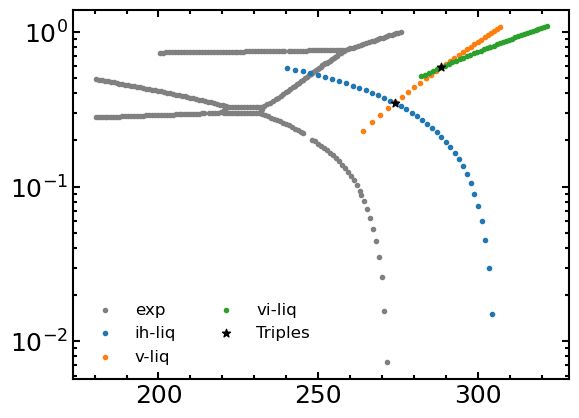

In [133]:
# plt.scatter(exp_liq['T'], exp_liq['P'], c='gray', label='exp')
# plt.plot(T_lst, np.array(P_lst)*1e-4, label='ACE')
# plt.scatter(ih_scan['T'], ih_scan['P'], label='DeepMD')
plt.scatter(exp_pd['T'], exp_pd['P']*1e-3, c='gray', label='exp', marker='.')
plt.scatter(ih_liq[0,:],ih_liq[1,:], label='ih-liq', marker='.')
plt.scatter(v_liq[0,:],v_liq[1,:], label='v-liq', marker='.')
plt.scatter(vi_liq[0,:],vi_liq[1,:], label='vi-liq', marker='.')
plt.yscale('log')

plt.scatter(T_triple_ih_liq, P_triple_ih_liq, marker='*', color='k')
plt.scatter(T_triple_v_vi, P_triple_v_vi, marker='*', color='k', label='Triples')

plt.legend(frameon=0, loc='best', fontsize=12, ncol=2)